In [ ]:
# Reference: 
# https://github.com/SenYan1999/SMART
# https://github.com/namisan/mt-dnn
# https://github.com/yaodongyu/TRADES

In [ ]:
pip install transformers

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

URL = '/content/gdrive/MyDrive/CSC413/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertModel, get_linear_schedule_with_warmup
from transformers import InputExample, InputFeatures

bert_model = BertModel.from_pretrained("bert-base-uncased", return_dict=False)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# train = pd.read_csv(URL + 'training.1600000.processed.noemoticon.csv',  encoding = "ISO-8859-1")

In [ ]:
# # Create a smaller train set for debugging purposes
# n = 100000
# smaller_set = train.sample(n)
# print(smaller_set)
# smaller_set.to_csv(URL + 'train_' +str(n) + '.csv', index=False)

In [ ]:
# lengths = df['text'].map(lambda x: len(x.split(" ")))
# lengths.hist()

In [ ]:
# classes = df['class']
# classes.hist(bins=3)

In [ ]:
df = pd.read_csv(URL + 'train_100000.csv',  encoding = "ISO-8859-1", 
                 names=["class", "id", "date", "query", "user", "text"])
# Make train, valid and test sets
df['class'] = df['class']/4 # Normalize classification

df = df.drop(0)
# print(df)

df_train, df_test = train_test_split(
  df,
  test_size=0.3,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((70000, 6), (15000, 6), (15000, 6))

In [ ]:
sample_txt = "@Naz I can't believe you would do that to me!"
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: @Naz I can't believe you would do that to me!
   Tokens: ['@', 'na', '##z', 'i', 'can', "'", 't', 'believe', 'you', 'would', 'do', 'that', 'to', 'me', '!']
Token IDs: [1030, 6583, 2480, 1045, 2064, 1005, 1056, 2903, 2017, 2052, 2079, 2008, 2000, 2033, 999]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32, # Most tweets have 10-15 words
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
class PGD(object):
    def __init__(self, model, epsilon, alpha, device, eta=1e-3):
        super(PGD, self).__init__()
        self.embed_bak = {}
        self.grad_bak = {}
        self.model = model
        self.epsilon = epsilon
        self.alpha = alpha
        self.eta = eta
        self.device = device

    def attack(self, emb_name='embeddings.', is_first_attack=False):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                if is_first_attack:
                    self.embed_bak[name] = param.data.clone().to(self.device)
                norm = torch.norm(param.grad)
                if norm != 0 and not torch.isnan(norm):
                    r_at = self.alpha * param.grad / norm
                    param.data.add_(r_at)
                    param.data = self.project(name, param.data)

    def project(self, param_name, param_data):
        r = param_data - self.embed_bak[param_name]
        if torch.norm(r) > self.epsilon:
            r = self.epsilon * r / torch.norm(r)
        return self.embed_bak[param_name] + self.eta * r

    def restore(self, emb_name = 'embeddings.'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.embed_bak
                param.data = self.embed_bak[name]
        self.embed_bak = {}

    def grad_backup(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.grad_bak[name] = param.grad.clone().to(self.device)

    def restore_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.grad_bak
                param.grad = self.grad_bak[name]

In [ ]:
class BPP(object):
    def __init__(self, model, beta, mu, device):
        self.model = model
        self.beta = beta
        self.mu = mu
        self.theta_til = {}
        self.device = device
        for name, param in self.model.named_parameters():
            self.theta_til[name] = param.data.clone().to(self.device)

    def theta_til_backup(self, named_parameters):
        for name, param in named_parameters:
            self.theta_til[name] = (1-self.beta) * param.data.clone().to(self.device) + self.beta * self.theta_til[name]

    def bregman_divergence(self, batch, logits):
        theta_prob = F.softmax(logits, dim=-1).to(self.device)

        param_bak = {}
        for name, param in self.model.named_parameters():
            param_bak[name] = param.data.clone().to(self.device)
            param.data = self.theta_til[name]

        with torch.no_grad():
            theta_til_prob = F.softmax(self.model(*batch), dim=-1).to(self.device)

        for name, param in self.model.named_parameters():
            param.data = param_bak[name]

        bregman_divergence = F.kl_div(theta_prob.log(), theta_til_prob, reduction='batchmean').to(self.device) + \
            F.kl_div(theta_til_prob.log(), theta_prob, reduction='batchmean').to(self.device)

        return bregman_divergence

In [ ]:
class TwitterDataset(Dataset):

  def __init__(self, tweets, classes, tokenizer, max_len):
    self.tweets = tweets
    self.classes = classes
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    text = str(self.tweets[item])
    target = self.classes[item]

    encoding = tokenizer.encode_plus(
      text,
      max_length=self.max_len, 
      truncation=True,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',  # Return PyTorch tensors
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'target': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
max_len = 32 # Most tweets have 10-15 words, max is 47

train_dataset = TwitterDataset(
    tweets=df_train["text"].to_numpy(),
    classes=df_train["class"].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

val_dataset = TwitterDataset(
    tweets=df_val["text"].to_numpy(),
    classes=df_val["class"].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

test_dataset = TwitterDataset(
    tweets=df_test["text"].to_numpy(),
    classes=df_test["class"].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, bert_model):
    super(SentimentClassifier, self).__init__()

    self.bert = bert_model

    # for param in self.bert.parameters():
    #   param.requires_grad = False

    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, 2)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
def eval_model(model, data_loader, len_data, loss_fn,v_loss, v_acc):
  model = model.eval()
  losses = []
  corrects = []
  correct_predictions = 0
  num = 0
  interval = np.linspace(0, len(data_loader), num=11)
  i = 0

  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["target"].to(device)

      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct = torch.sum(preds == targets)
      corrects.append((correct/len(preds)).item())
      correct_predictions += correct
      losses.append(loss.item())

      if num >= interval[i]:
        v_loss.append(np.mean(losses))
        v_acc.append(np.mean(corrects))
        i += 1
      num += 1

  return correct_predictions.double() / len_data, np.mean(losses)

In [ ]:
def train_epoch(model, train_data_loader, len_data, loss_fn, t_loss, t_acc):
  losses = []
  corrects = []
  correct_predictions = 0
  num = 0
  interval = np.linspace(0, len(train_data_loader), num=11)
  i = 0

  for batch in train_data_loader: # Each batch in data loader
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["target"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct = torch.sum(preds == targets)
      corrects.append((correct/len(preds)).item())
      correct_predictions += correct
      losses.append(loss.item())
      loss.backward()

      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip the grad to 1

      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()

      if num >= interval[i]:
        t_loss.append(np.mean(losses))
        t_acc.append(np.mean(corrects))
        i += 1
      num += 1

  train_acc= correct_predictions.double() / len_data
  train_loss = np.mean(losses)
  return train_acc, train_loss

In [ ]:
def train_smart_epoch(model, train_data_loader, len_data, loss_fn, pgd, bpp, t_loss, t_acc):
  losses = []
  corrects = []
  correct_predictions = 0
  num = 0
  interval = np.linspace(0, len(train_data_loader), num=11)
  i = 0

  for batch in train_data_loader: # Each batch in data loader
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      targets = batch["target"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct = torch.sum(preds == targets)
      corrects.append((correct/len(preds)).item())
      correct_predictions += correct
      losses.append(loss.item())
      loss.backward(retain_graph=True)

      pgd_k = 1

      # PGD Adversarial Training
      pgd.grad_backup()
      for k in range(pgd_k):
        pgd.attack(is_first_attack=(k == 0))
        if k != pgd_k - 1:
          model.zero_grad()
        else:
          pgd.restore_grad()
          out_adv = model(input_ids, attention_mask)
          loss_adv = F.cross_entropy(out_adv, targets)
          loss_adv.backward()
    
      pgd.restore()

      # Bregman Proximal Point Optimization
      bregman_div = bpp.mu * bpp.bregman_divergence((input_ids, attention_mask), outputs)
      bregman_div.backward()

      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip the grad to 1

      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()

      bpp.theta_til_backup(model.named_parameters())

      if num >= interval[i]:
        t_loss.append(np.mean(losses))
        t_acc.append(np.mean(corrects))
        i += 1
      num += 1

  train_acc= correct_predictions.double() / len_data
  train_loss = np.mean(losses)
  return train_acc, train_loss

In [ ]:
def train(model,
  train_dataset,
  val_dataset,
  loss_fn,
  optimizer,
  scheduler,
  num_epochs,
  batch_size,
  pgd=None,
  bpp=None,
  smart=True):

  train_data_loader = DataLoader(train_dataset, batch_size=batch_size)
  val_data_loader = DataLoader(val_dataset, batch_size=batch_size)

  t_loss, t_acc, v_loss, v_acc = [], [], [], []

  for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    model = model.train()

    if smart:
      train_acc, train_loss = train_smart_epoch(model, train_data_loader, len(train_dataset), loss_fn, pgd, bpp, t_loss, t_acc)
    else:
      train_acc, train_loss = train_epoch(model, train_data_loader, len(train_dataset), loss_fn, t_loss, t_acc)
    print(f'Train loss {train_loss} accuracy {train_acc}')
    print(len(t_loss), len(t_acc))
    # t_loss.append(train_loss)
    # t_acc.append(train_acc)

    val_acc, val_loss = eval_model(model, val_data_loader, len(val_dataset), loss_fn, v_loss, v_acc)
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print(len(v_loss), len(v_acc))

    # v_loss.append(val_loss)
    # v_acc.append(val_acc)

    print()
  return t_loss, t_acc, v_loss, v_acc

In [ ]:
device = torch.device("cuda:0")# if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(bert_model)
model = model.to(device)
epsilon = 1e-5
alpha = 3 # 1, 3, 5
beta = 0.99
mu = 1
pgd = PGD(model, epsilon, alpha, device)
bpp = BPP(model, beta, mu, device)
smart = False

In [ ]:
epochs = 3 # max 6
lr = 1e-5 # {1×10−5, 2×10−5, 3×10−5, 5×10−5}
batch_size = 128 # {16,32,64}

optimizer = optim.Adam(model.parameters(), lr=lr)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size)
total_steps = len(train_data_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
  )
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
if smart:
  t_loss, t_acc, v_loss, v_acc = train(model, train_dataset, val_dataset, loss_fn, optimizer, scheduler, epochs, batch_size, pgd=pgd, bpp=bpp)
else:
  t_loss, t_acc, v_loss, v_acc = train(model, train_dataset, val_dataset, loss_fn, optimizer, scheduler, epochs, batch_size, smart=False)

Epoch 1/3
----------
Train loss 0.32324061315281954 accuracy 0.8636857142857143
10 10
Val loss 0.37457853378885886 accuracy 0.8383333333333334
10 10

Epoch 2/3
----------
Train loss 0.2737048730608314 accuracy 0.8896714285714286
20 20
Val loss 0.3903566053358175 accuracy 0.8358666666666668
20 20

Epoch 3/3
----------
Train loss 0.24534079296279432 accuracy 0.9036714285714286
30 30
Val loss 0.4151996905773373 accuracy 0.8361333333333334
30 30



In [ ]:
# torch.save(model.state_dict(), URL + 'SMART.pt')

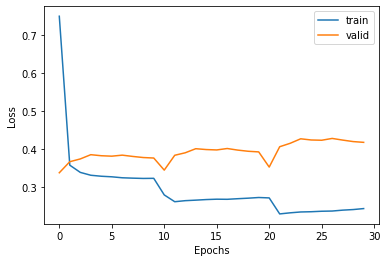

In [ ]:
eps = range(epochs * 10)

plt.plot(eps, t_loss, label="train")
plt.plot(eps, v_loss, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

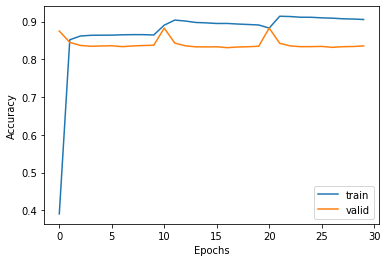

In [ ]:
eps = range(epochs * 10)

plt.plot(eps, t_acc, label="train")
plt.plot(eps, v_acc, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

Notes:

Without Adv, val acc ~79.9%, train acc ~95%

With Adv, val acc ~ 83.8%, train acc ~85.9% <- after 2 epochs

In [ ]:
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_acc, test_loss = eval_model(model, test_data_loader, len(test_dataset), loss_fn, [], [])
print(f'Test loss {test_loss} accuracy {test_acc}')

Test loss 0.4198757095609681 accuracy 0.8322


In [ ]:
for e = 1...EPOCHS:
   for inputs, targets in BATCH:

      logits = SentimentClassifier(inputs)
      loss = CrossEntropyLoss(logits, targets)

      ~inputs = Adversarial(inputs)
      ~logits = SentimentClassifier(~inputs)
      ~loss = CrossEntropyLoss( ~logits, targets)

      theta` -> AdamUpdate(loss + Lamda * ~loss)
      theta -> u * Bregman(theta`)
    end for
end for

return: theta

In [ ]:
df_test.tail()

,class,id,date,query,user,text
99074,0.0,2006669281,Tue Jun 02 11:30:32 PDT 2009,NO_QUERY,peacetara,@furrygirl I didn't get to see you yesterday! ...
67240,1.0,2071479293,Sun Jun 07 19:27:51 PDT 2009,NO_QUERY,emeraldashlee,@LpThePharaoh it wass fuuunnnn me &amp; @chan...
8023,1.0,1986092743,Sun May 31 18:18:39 PDT 2009,NO_QUERY,patricktimothyy,had alot of fun at the carnival i wish it was...
91104,1.0,1691345726,Sun May 03 17:39:23 PDT 2009,NO_QUERY,WarrenWhitlock,@dsalzmann why would I want to be a &quot;fres...
805,1.0,2178280549,Mon Jun 15 07:28:02 PDT 2009,NO_QUERY,EnoxiSureka,@terakopian Good to hear I'm not the only one ...


In [ ]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

correct = 0
for index, row in df_test.iterrows():
  score = classifier(row["text"])[0]["label"]
  if score == "NEGATIVE" and row["class"] == 0:
    correct += 1
  elif score == "POSITIVE" and row["class"] == 1:
    correct += 1

accuracy = correct/len(df_test)
print(accuracy)

0.7044666666666667
